# COMP2211 PA2 MLP (Multilayer Perceptron) vs. CNN (Convolutional Neural Network) 

## Introduction

AI models, including both MLPs and CNNs, can effectively classify and recognize different objects. You may already know that they can classify handwritten digits into classes. Actually, they can identify more than you can think of. For example, different types of clothes!


## Task Overview
In this assignment, you will implement both an MLP-based and a CNN-based image classification model to classify different types of clothes (T-shirt, trouser, coat, etc.). 

Different from previous labs and PAs where you are required to implement from scratch, in this task we are using the Keras library, a simplified set of API<a href="#API"><sup>1</sup></a> on top of the famous TensorFlow library.
The links to the documentation of each task's relevant function are provided in the task description.
You can generally refer to them to see how to call each Keras function.

In addition, Keras provides multiple coding paradigms and API patterns for some functions.
And some are not comprehensively documented!
(E.g. string shorthands for activation functions, kernel initializers, losses, etc.)

Nonetheless,
they provided many official code examples, where many alternative paradigms and underdocumented API shorthands are demonstrated:
* [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) (MNIST is another image dataset on handwritten digits)
* [Basic image classification](https://www.tensorflow.org/tutorials/keras/classification)
* [Image classification](https://keras.io/examples/vision/image_classification_from_scratch/)
* [Intro to Keras for engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/)


## In this programming assignment..

* There is one function for each task.
    * When you finish all the required tasks, please move your code to the submission template `pa2.py` and submit it to ZINC.

* We don't expect you as a pro in defining Python functions. You only need to:
    * Utilize only the parameters provided in the function definition
    * Write your code between the comments *START YOUR CODE HERE* and *END YOUR CODE HERE*.
    * When writing each task, imagine the provided parameters in the function and the imported libraries are all you need.
    * Don't modify the parameter list of each function.
    Or you will confuse Zinc when we call these functions to evaluate your tasks.
* There are some dummy codes in each task already.
    * They are for ensuring the notebook will run without errors, even if you do nothing.
    * Feel free to remove and replace them, or refer to them (e.g., the expected shape, how to call `keras.Sequential`, etc.)
    * The yellow `print` statements are merely informational.
    We will *not* grade by checking the presence of these `print`s.
    Feel free to remove them or keep them (if you don't feel bothered).

---------

<a id="API">1</a>: API Stands for *Application Programming Interfaces*. Here we refer to all the functions, classes, etc., provided by libraries like Keras & TensorFlow.


In [1]:
# Provided: notebook bootstrapping
# Keras Models
import tensorflow as tf
import keras 
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.datasets import fashion_mnist

# Additional Libs
import numpy as np
import os
import matplotlib.pyplot as plt


In [30]:
from google.colab import drive
drive.mount("/content/drive")
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cnn_model.h5  drive/  mlp_model.h5  sample_data/


## Introduction to the Dataset

The dataset we will use in this PA is [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


### Loading the dataset

Keras has a built-in API for loading some existing [famous baseline dataset](https://keras.io/api/datasets/). Luckily, Fashion-MNIST is one of them. So we directly load the dataset with `keras.datasets.fashion_mnist.load_data` and we will get:


* `X_train` has 60000 training images, size of each image should be `(28,28)`
* `y_train` is a list of length 60000 containing the ground-truth label of those images, each being an integer in `[0, 9]`.
* Similar for `X_test` & `y_test`. But the size should be 10000 instead of 60000.

In [2]:
# Provided: loading dataset from keras.datasets

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Shape of X_train:{}".format(X_train.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of X_test:{}".format(X_test.shape))
print("Shape of y_test:{}".format(y_test.shape))

Shape of X_train:(60000, 28, 28)
Shape of y_train:(60000,)
Shape of X_test:(10000, 28, 28)
Shape of y_test:(10000,)


### Data preprocessing for MLP

Recall: MLPs (Multilayer Perceptron) use one perceptron for each input (e.g. pixel in an image). The input of MLP should be 1D rather than 2D.

Additionally, the data range of original X_train and X_test spread from 0 to 255. So it requires normalizing and reshaping it to 1D array for training neural network.

Note that each label is an integer in $[0, 9]$.
It follows that each element of `y_train` and `y_test` is 1D.

Like previous labs, we transform a single integer to a one-hot encoding vector of length 10, which is the total number of possible labels.


Here we use [`tf.keras.utils.to_categorical`](https://keras.io/api/utils/python_utils/#tocategorical-function) to encode
for the maximum code compatibility and minimum library imports.




In [3]:
# Provided: normalize it and reshape

X_train = X_train / 255.
X_train = X_train.reshape([-1, 28*28])
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
y_train_bak = y_train

X_test = X_test / 255.
X_test = X_test.reshape([-1, 28*28])
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)
y_test_bak = y_test

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Finish Normalizing and Reshaping")

Finish Normalizing and Reshaping


### Sample data visualization

Check the dataset manually is important, one way to do so is to plot and visualize the images directly. In this section, we'll visualize each label of image in a 5x5 matrix.

You should see 25 randomly selected images from the dataset. You can repeatedly run this code section and the visualized samples are different every time.

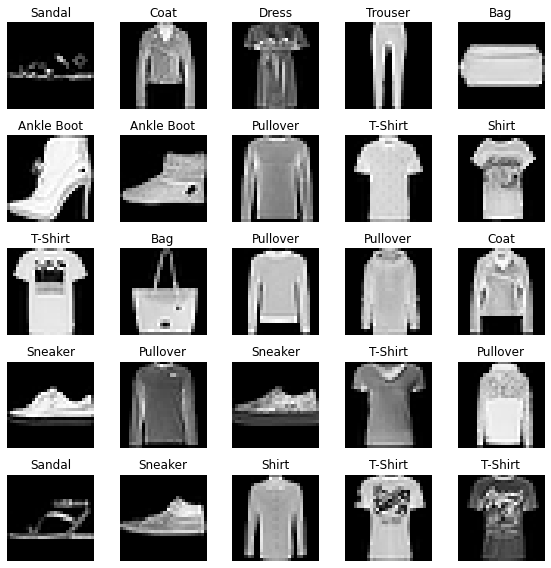

In [4]:
# Provided: sample data visualization

labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
        5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8, 8))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(X_train))
    img = X_train[data_idx].reshape([28, 28])
    label = labels_map[y_train_bak[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Task 1.1: Build an MLP Model



*   In the input layer, you are expected to implement a Dense layer with 256 nodes, and it accepts 28x28-shaped(or 784) input. Since the shape of the image is 28x28, and 1D array converted from a 2D array will enter here. So you need to define input_shape here. Note that the input_shape argument has to be a tuple type.
*   Add [`Batch Normalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) layer. Batch Normalization can reduce the effect of Internal Covariate Shift, which would maintain the information distribution to be a normal distribution.
*   Add the ReLU activation function. 
*   Since this task is a multi-class classification, the Softmax activation function should be added at the end of the output layer.

In summary, you should create a `Sequential` model of the following architecture (Please note that there are only four layers, do not add additional layers such as `keras.Input`):
* A dense layer with an output dimension 256 
* A [`Batch Normalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) layer
* A ReLU activation (function) layer
* A dense layer with output dimension 10 and softmax activation




In [5]:
# TODO: Build a simple MLP with 2 Dense Layers.

def build_mlp_model():
    model = keras.Sequential(name='mlp')

    # Add Flatten Layer
    model.add(Dense(units=256, input_shape = (784,)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Add Output Layer
    model.add(Dense(10, activation='softmax'))

    return model

mlp_model = build_mlp_model()
mlp_model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 204,554
Trainable params: 204,042
Non-trainable params: 512
_________________________________________________________________


## Task 1.2: Compile an MLP Model

In Keras' terms, compiling a model is to set
the loss function,
the optimizer (a.k.a. the learning rate and other related stuff), and
the evaluation metrics (e.g., accuracy).

Refer to the [`model.compile`](https://keras.io/api/models/model_training_apis/#compile-method) documentation.
Implement a function that **receives a model and a learning rate as parameters** and compiles the model using
* [`categorical_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as loss function,
* [`Adam`](https://keras.io/api/optimizers/adam/) optimizer, 
* Learning rate 0.1 for Adam Optimizer, and
* only [`accuracy`](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) metric.



> If you found problems using `keras.optimizers.Adam(…)` or `from keras.optimizers import Adam`, try to use `tf.keras.optimizers.Adam(…)`.



In [6]:
# TODO: define the optimizer, loss function, learning rate, and metrics

def compile_mlp_model(mlp_model):

    mlp_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    mlp_loss = 'categorical_crossentropy'
    mlp_metrics = ['accuracy']

    mlp_model.compile(optimizer=mlp_optimizer, loss=mlp_loss, metrics=mlp_metrics)
    return mlp_model

mlp_model = compile_mlp_model(mlp_model)

## Task 1.3: Model Training

Refer to [`model.fit`](https://keras.io/api/models/model_training_apis/#fit-method) documentation.
Implement a function that trains a given model using
given `x_train` & `y_train`, batch size, and given #epochs.


In [7]:
# TODO: use model.fit() and input correct data, label, batch_size, epochs parameter

def train_model(model, train_epochs, bs, x_train, y_train):
    return model.fit(x_train, y_train, batch_size = bs, epochs = train_epochs)
    
mlp_history = train_model(model = mlp_model, train_epochs = 5, bs = 512, x_train = X_train, y_train = y_train)

Epoch 1/5
118/118 [==============================] - 4s 29ms/step - loss: 0.7034 - accuracy: 0.7728
Epoch 2/5
118/118 [==============================] - 3s 25ms/step - loss: 0.3961 - accuracy: 0.8550
Epoch 3/5
118/118 [==============================] - 3s 27ms/step - loss: 0.3696 - accuracy: 0.8643
Epoch 4/5
118/118 [==============================] - 4s 31ms/step - loss: 0.3367 - accuracy: 0.8764
Epoch 5/5
118/118 [==============================] - 4s 33ms/step - loss: 0.3137 - accuracy: 0.8831


## Task 1.4: Model Evaluation

Refer to [`model.evaluate`](https://keras.io/api/models/model_training_apis/#evaluate-method) documentation.
Implement a function that evaluates the model given `x_test` & `y_test` in a batch size of 64.

You can evaluate the MLP model we train right away. Your model is expected to reach a test accuracy > 80%.


In [8]:
# TODO: use model.evaluate() to test a given model with given test set

def test_model(model, x_test, y_test):
    return model.evaluate(x = x_test, y = y_test)

loss, acc = test_model(mlp_model, X_test, y_test)
print('test loss is {}'.format(loss))
print('test accuracy is {}'.format(acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.4492 - accuracy: 0.8526
test loss is 0.4492003321647644
test accuracy is 0.8525999784469604


##Visualization of MLP prediction

To check whether our MLP model can successfully identify and classify the clothes images. We randomly selected some samples in the test set and predicted them with our model. The correct prediction is marked in blue and the wrong prediction with ground truth is marked in red.

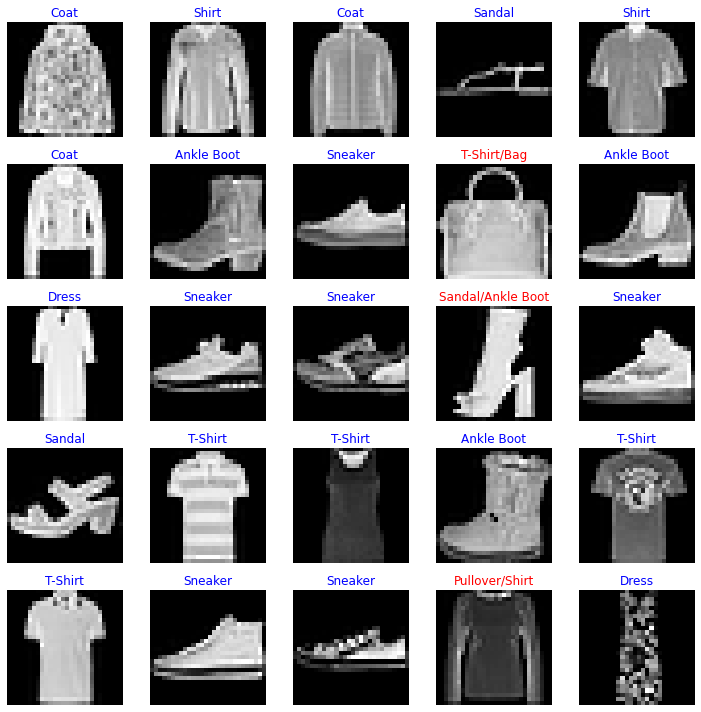

In [9]:
# Provided
test_batch_size = 25
batch_index = np.random.choice(len(X_test), size=test_batch_size, replace=False)

batch_xs = X_test[batch_index]
batch_ys = y_test_bak[batch_index]
y_pred_ = mlp_model(batch_xs, training=False)

fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(batch_xs, batch_ys, y_pred_)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred) == py:
        p.set_title("{}".format(labels_map[py]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred)],
                               labels_map[py]), color='red')
    p.imshow(px.reshape(28, 28), cmap='gray')
    p.axis('off')
plt.tight_layout()

## Task 2.1 Build a CNN model

In summary, you should create a `Sequential` model of the following architecture:
* A convolutional layer with 16 3*3 kernels, ReLU activation, and ["He uniform"](https://keras.io/api/layers/initializers/#heuniform-class) kernel initializer
* A 2*2 max pooling layer
* A flatten layer to squash the 3D data to 1D
* A dense layer with output dimension 100, relu activation, and ["He uniform"](https://keras.io/api/layers/initializers/#heuniform-class) kernel initializer
* A dense layer with output dimension 10 and softmax activation

Please refer to [their documentation](https://keras.io/api/layers/) for detailed usage.

Usually, we pass in the `input_shape` parameter to the first layer.
But since the first layer is our customized function receiving no parameters,
we tell the model the input shape by a `model.build` function after definition.
This line is provided for you.

> Note that in lecture notes and many other demonstrations codes,
> we can provide a string name shorthand for
> initializers and activation functions,
> as long as we use them *with their default parameters*.
> In this case, you can use either string shorthands or
> the longer version in PA.

-----

<a id="extend-preprocess">1</a>: Extended reading: [Preprocessing data before the model or inside the model](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model)

In [10]:
# TODO: Build a simple CNN with 2 Dense Layers.

def build_cnn_model():

    model = keras.Sequential(name = 'cnn')

    model.add(Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))

    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               270500    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 271,670
Trainable params: 271,670
Non-trainable params: 0
_________________________________________________________

## Task 2.2: Compile a CNN Model

Similar to task 1.2. You also need to compile the CNN model you built to prepared for the training.

Refer to the [`model.compile`](https://keras.io/api/models/model_training_apis/#compile-method) documentation.
Implement a function that compiles the model using
* [`categorical_crossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as loss function,
* [`SGD`](https://keras.io/api/optimizers/sgd/) optimizer and momentum=0.9 for SGD Optimizer, 
* Learning rate 0.01 for SGD Optimizer, and
* only [`accuracy`](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) metric.



> If you found problems using `keras.optimizers.SGD(…)` or `from keras.optimizers import SGD`, try to use `tf.keras.optimizers.SGD(…)`.

In [11]:
# TODO: define the optimizer, loss function, learning rate, and metrics

def compile_cnn_model(cnn_model):

    cnn_optimizer = tf.keras.optimizers.SGD(lr = 0.01, momentum = 0.9)
    cnn_loss = 'categorical_crossentropy'
    cnn_metrics = ['accuracy']

    cnn_model.compile(optimizer=cnn_optimizer, loss=cnn_loss, metrics=cnn_metrics)
    return cnn_model

cnn_model = compile_cnn_model(cnn_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Task 2.3: Data Reshaping for CNN Training

At the very beginning of this lab, remember that we reshape `X_train` and `X_test` to make sure that they can be the input for MLP model training. However, the expected input for CNN is 4D (`<num_data,height,width,channels>`)

Implement a function that reshapes 2D `X_train`, `X_test` into 4D NumPy arrays.

If your implementation on the reshaping is correct, The CNN will be trained with the reshaped data. Note that CNN training make take longer time (~20s per epoch) than MLP training


In [12]:
# TODO: reshape the data for CNN training

def reshape_data(X_train, X_test):

    X_train_reshape = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test_reshape = X_test.reshape((X_test.shape[0], 28, 28, 1))

    return X_train_reshape, X_test_reshape

X_train_cnn, X_test_cnn = reshape_data(X_train, X_test)
cnn_history = train_model(model = cnn_model, train_epochs = 5, bs = 256, x_train = X_train_cnn, y_train = y_train)

Epoch 1/5
235/235 [==============================] - 15s 63ms/step - loss: 0.6164 - accuracy: 0.7769
Epoch 2/5
235/235 [==============================] - 15s 62ms/step - loss: 0.4102 - accuracy: 0.8550
Epoch 3/5
235/235 [==============================] - 15s 62ms/step - loss: 0.3716 - accuracy: 0.8687
Epoch 4/5
235/235 [==============================] - 16s 66ms/step - loss: 0.3333 - accuracy: 0.8816
Epoch 5/5
235/235 [==============================] - 15s 65ms/step - loss: 0.3103 - accuracy: 0.8902


## CNN Evaluation
Use the `test_model()` function implemented in task 1.4, you can evaluate the CNN model now. Your CNN model is expected to reach a test accuracy > 85%.

In [13]:
# Provided

loss, acc = test_model(cnn_model, X_test_cnn, y_test)
print('test loss is {}'.format(loss))
print('test accuracy is {}'.format(acc))

313/313 [==============================] - 2s 5ms/step - loss: 0.3307 - accuracy: 0.8821
test loss is 0.330691397190094
test accuracy is 0.882099986076355


##Visualization of CNN prediction

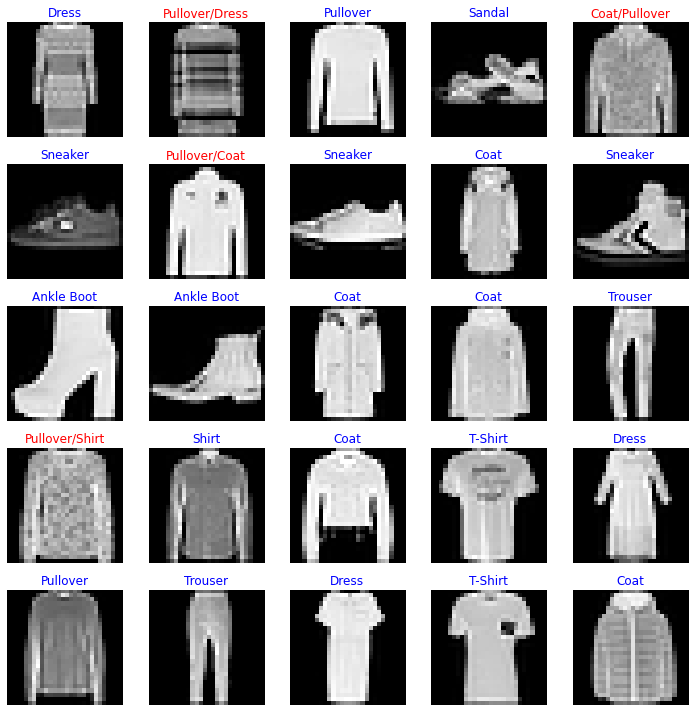

In [14]:
# Provided

test_batch_size = 25
batch_index = np.random.choice(len(X_test_cnn), size=test_batch_size, replace=False)

batch_xs = X_test_cnn[batch_index]
batch_ys = y_test_bak[batch_index]
y_pred_ = cnn_model(batch_xs, training=False)

fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(batch_xs, batch_ys, y_pred_)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred) == py:
        p.set_title("{}".format(labels_map[py]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred)],
                               labels_map[py]), color='red')
    p.imshow(px.reshape(28, 28), cmap='gray')
    p.axis('off')
plt.tight_layout()

## Compare MLP vs. CNN

From previous tasks, you may notice some difference between MLP and CNNs. For example, the input shape of MLP and CNN are quite different. Here we use matplotlib to visulize the training history of CNN and MLP.

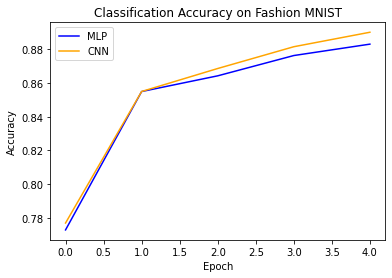

In [15]:
# Provided

from matplotlib import pyplot as plt
def compare_training(history_mlp, history_cnn):
  # plot accuracy
  plt.subplot(111)
  plt.title('Classification Accuracy on Fashion MNIST')
  plt.plot(history_mlp.history['accuracy'], color='blue', label='MLP')
  plt.plot(history_cnn.history['accuracy'], color='orange', label='CNN')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()
  return
 
compare_training(mlp_history,cnn_history)

### Optional Task: Create better model with data augmentation 

You may notice that your model can achieve even 90% accuracy during training, but only get around 85% accuracy on the test set. This is because your model **overfit** on the training set. Data augmentation is a trick to alliviate this effect.

Data augmentation is to randomly perturb our image data to generate more input data.

Build a CNN model that included data augmentation layer.
The model should do the following augmentation in sequence.

1. Randomly flip (or not) an image horizontally
2. Randomly rotate an image within the range `[-0.1 * 2π，0.1 * 2π]`
and fill those points outside the boundary with a constant value of zero (black background)

You may refer to the documentation for
[`RandomFlip`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/),
[`RandomRotation`](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/) and
[`Sequential`](https://keras.io/guides/sequential_model/).



In [16]:
from keras.layers import RandomFlip, RandomRotation

def build_aug_model():

  model_aug = keras.Sequential(name='model_aug')

  ### START YOUR CODE HERE



  ### END YOUR CODE HERE
  
  return model_aug


The training of this model with data augmentation may take even longer time than the training of vanilla CNN you built in task2. It is also not guaranteed that this model may outperform previous one with higher accuracy (This is because the model size and size of dataset is not that large). But you should notice that the gap between training accuracy and test accuracy are reduced.

You can start training via uncommenting `aug_model_train()` in the following code block, but do remember to comment it in your submission!

In [17]:
def aug_model_train():
  # Provided
  aug_cnn_model = build_aug_model()
  aug_cnn_model.build(input_shape=(None, 28, 28, 1)) 
  aug_cnn_model.summary()

  compile_cnn_model(aug_cnn_model)
  aug_cnn_history = train_model(model = aug_cnn_model, train_epochs = 5, bs = 128, x_train = X_train_cnn, y_train = y_train)
  loss, acc = test_model(aug_cnn_model, X_test_cnn, y_test)
  print('test loss is {}'.format(loss))
  print('test accuracy is {}'.format(acc))

#aug_model_train()

## Saving the model (IMPORTANT!)

After you trained a model with satisfied accuracy, you can save this model as a `.h5` file with `model.save`. You can reload it if your would like to use it again. The two `.h5` files should be included in your submission to ZINC.

In [18]:
# Provided
mlp_model.save("mlp_model.h5")
cnn_model.save("cnn_model.h5")

In [19]:
%ls

cnn_model.h5  mlp_model.h5  sample_data/


loading

## MLP vs. CNN on Image Classification

After these tasks, you may notice that CNNs outperforms MLPs on image classification tasks. But Why and How?

* MLPs (Multilayer Perceptron) use one perceptron for each input (e.g. pixel in an image) and the amount of weights rapidly becomes unmanageable for large images. It includes too many parameters because it is fully connected. Each node is connected to every other node in next and the previous layer, forming a very dense web — resulting in redundancy and inefficiency. As a result, difficulties arise whilst training and overfitting can occur which makes it lose the ability to generalize.

* Another common difference between MLPs and CNNs is that MLPs react differently to an input (images) and its shifted version — they are not translation invariant. For example, if a picture of a cat appears in the top left of the image in one picture and the bottom right of another picture, the MLP will try to correct itself and assume that a cat will always appear in this section of the image.

* Hence, compared to CNNs, MLPs are not the best idea to use for image processing. One of the main problems is that spatial information is lost when the image is flattened(matrix to vector) into an MLP. We thus utilize CNNs to leverage the spatial correlation of the image features (pixels) in such a way that we can see the cat in our picture no matter where it may appear. 


## More to explore...

If you want to explore more, here is list that include something you can try:

* (Highly Recommended) Try [Tensorflow-Playground](https://playground.tensorflow.org/) 
    * TensorFlow Playground is an extremely awesome website where you can visualize and intuitively understand how neural networks work. This website, developed by the TensorFlow team at Google, is one of the best platforms that will allow you to explore the powerful deep neural networks.
    * Feel free to try different learning rate, data distribution, number of layers and neurons, activations, regularizations.

* Practice NumPy indexing and vectorization techniques
    * Write your *own* code to calculate the confusion matrix on `x_test` and `y_test`.
    Use *only* `model.predict` and *no* `tf.math.confusion_matrix`.
    * Implement a convolution operation (given a piece/batch of data and a kernel) yourself, using as few for-loops as possible.
* Towards a better model
    * Experiment with other model architectures.
    * Tune parameters. You may check lecture notes, Keras API documentation
    and online materials to see what parameters you can tune.
    * Try out Keras callbacks like [`ReduceLROnPlateau`.](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
* Keep track of model statistics
    * Try out [Tensorboard callback](https://keras.io/api/callbacks/tensorboard/).
* Play with other datasets
    * Explore other popular datasets.
    [TensorFlow](https://www.tensorflow.org/datasets/catalog/overview?hl=zh-cn#image_classification) and
    [Keras](https://keras.io/api/datasets/)
    also ship with some most popular datasets already.
* Engineer a better ML pipeline
    * Explore other [keras callbacks](https://keras.io/api/callbacks/)
    * Try to save the images in the NumPy arrays as separate `png` files in a hierarchy preferred by
    [`keras.utils.image_dataset_from_directory`](https://keras.io/api/data_loading/image/#image_dataset_from_directory-function)
    and do the following parts of model building, compiling, training & evaluation.
    See what needs to be changed in the following parts.
    * Try to wrap the NumPy array data in a `tf.data.Dataset` object using [`tf.data.Dataset.from_tensor_slices`](https://www.tensorflow.org/tutorials/load_data/numpy).
    See how to specify dataset shuffling & batching in this case (and their order?),
    and what needs to be changed in the following parts.